### GloVe плюс линейная модель

Были подготовлены эмбеддинги для всего корпуса текстов пресс-релизов с помощью модели GloVe [https://github.com/stanfordnlp/GloVe](https://github.com/stanfordnlp/GloVe) c различной длиной вектора. Индекс векторов находится в каталоге `glove`.

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import re

import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
import utils

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 41825352

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True);

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Загрузка датасета:

In [ ]:
X = pd.read_csv('../data/x.csv', index_col='date')
y = pd.read_csv('../data/y.csv', index_col='date').iloc[:, 0]

metrics = pd.read_csv('metrics.csv', index_col=0)

Генерация векторов:

In [3]:
mystem = Mystem()
STOP_WORDS = set(stopwords.words('russian'))

def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    return ' '.join([word for word in text.split()])

# сохраняем корпус текстов в файл
with open('releases.txt', 'tw', encoding='utf-8') as f:
    for x in X.release.apply(preprocessor):
        f.write(x)
        f.write(' ')

# далее вызываем построение векторов при помощи glove для заданного размера вектора:
# vocab_count -min-count 5 -verbose 2 < releases.txt > vocab.txt
# cooccur -memory 4.0 -vocab-file vocab.txt -verbose 2 -window-size 15 < releases.txt > cooccurrence.bin
# shuffle -memory 4.0 -verbose 2 < cooccurrence.bin > cooccurrence.shuf.bin
# glove -save-file vectors -threads 8 -input-file cooccurrence.shuf.bin -x-max 10 -iter 15 -vector-size 50 -binary 2 -vocab-file vocab.txt -verbose 2

Класс преобразования документа в вектор на основе индекса векторов:

In [4]:
class GloveVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vectors_file, *, preprocessor=None, vector_size=-1):
        self._preprocessor = preprocessor
        self._vectors = {}
        
        with open(vectors_file, encoding="utf8") as f:
            for line in f:
                word, *vector = line.split()
                self._vectors[word] = np.array(vector, dtype=float)
                max_size = len(vector)
        
        self._vector_size = vector_size if vector_size >= 0 and vector_size < max_size else max_size
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        if self._preprocessor:
            X = X.apply(self._preprocessor).tolist()
        
        return np.array([
            np.mean([self._vectors[w][:self._vector_size] for w in words if w in self._vectors] 
                    or [np.zeros(self._vector_size)], axis=0)
            for words in X
        ])

In [5]:
def preprocessor(text):
    text = text.lower()
    regex = re.compile('[^а-я А-ЯЁё]')
    text = regex.sub(' ', text)
    text = ' '.join(mystem.lemmatize(text))
    return [
        word for word in text.split()
        if word not in STOP_WORDS
    ]


Подберем оптимальную длину вектора и параметры для SVM:

In [ ]:
auc = []
for vec_size in tqdm([50, 70, 90, 100]):
    vectorizer = GloveVectorizer(f'../glove/vectors.100d.txt', preprocessor=preprocessor, vector_size=vec_size)
    glove = vectorizer.fit_transform(X.release)
    glove = StandardScaler().fit_transform(glove)
    
    for c in [0.01, 0.05, 0.1, 0.5, 1, 3, 5, 7, 10]:
        for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
            auc.append(
                utils.calc_metrics(
                    glove, y,
                    SVC,
                    name='glove svc only release', 
                    kernel=kernel,
                    C=c,
                    plot=False, 
                    probability=True,
                    random_state=RANDOM_STATE
                    ) + (glove,)
                )

roc_auc, best_model, glove = max(auc, key=lambda x: x[0])

print(f"Лучшая модель - {best_model}")
print(f"ROC-AUC = {roc_auc}")
print(f"Vector size = {glove.shape[1]}")

100%|██████████| 4/4 [01:55<00:00, 28.81s/it]

Лучшая модель - SVC(C=10, probability=True, random_state=41825352)
ROC-AUC = 0.7701108959690196
Vector size = 100


              precision    recall  f1-score   support

        -1.0       0.73      0.70      0.71        23
         0.0       0.55      0.62      0.58        26
         1.0       0.71      0.63      0.67        19

    accuracy                           0.65        68
   macro avg       0.66      0.65      0.65        68
weighted avg       0.65      0.65      0.65        68



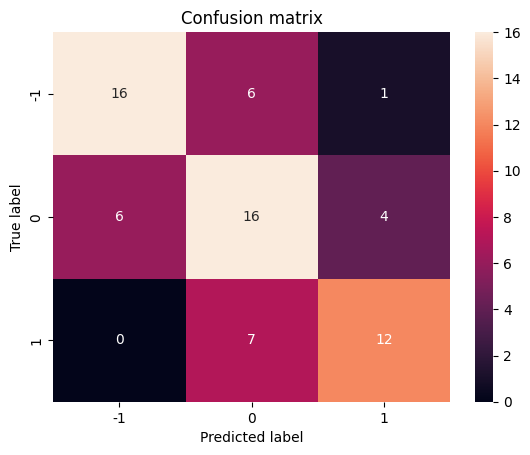

,accuracy,f1,precision,recall,roc_auc_ovr,roc_auc_ovo
min_baseline,0.659794,0.664127,0.664127,0.664127,0.742845,0.748095
bow l1 only release,0.632353,0.639291,0.645750,0.634718,0.755293,0.761178
bow elasticnet,0.676471,0.682804,0.696465,0.674852,0.837479,0.840521
bow release title,0.661765,0.666369,0.684816,0.657308,0.834681,0.837807
bow release all num,0.676471,0.681421,0.690476,0.676524,0.833032,0.836091
bow svc only release,0.632353,0.635330,0.639098,0.633046,0.773909,0.777299
tf_idf l1 only release,0.632353,0.633909,0.639423,0.633339,0.779854,0.785322
tf_idf only release best word,0.764706,0.769046,0.770299,0.770962,0.906871,0.909142
tf_idf title release,0.735294,0.740476,0.754672,0.732529,0.895373,0.898903
tf_idf numerical release,0.691176,0.694553,0.713392,0.686000,0.833339,0.835035


In [11]:
metric, model = utils.calc_metrics(glove, y, SVC, name='glove svc only release', **best_model.get_params())
metrics = pd.concat([metrics, metric], axis=0)
metrics

Как и в случае Word2Vec, качество лучшей модели получилось не слишком высоким.

In [12]:
metrics.to_csv('metrics.csv')